# Hierarchical Voronoi Binning

Isaac Cheng - October 2023

An example implementing hierarchical Voronoi binning, as described in the
[`vorbin` manual](https://www-astro.physics.ox.ac.uk/~cappellari/software/vorbin_manual.pdf).

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import zarr

from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
from vorbin.voronoi_2d_binning import voronoi_2d_binning

BASEPATH = "/arc/projects/mauve/products/v0.3/IC3392/pipeline.tmp/"

In [2]:
# Read in data. They must all be the same size
# In this case, our data are 1D, but it turns out the subsequent steps (i.e., regularly
# binning the arrays) is easier if you have 2D data. We will transform the data back into
# 2D
x = zarr.load(BASEPATH + "x.zarr").reshape(438, 437)
y = zarr.load(BASEPATH + "y.zarr").reshape(438, 437)
signal = zarr.load(BASEPATH + "signal.zarr").reshape(438, 437)
noise = zarr.load(BASEPATH + "noise.zarr").reshape(438, 437)
snr = zarr.load(BASEPATH + "snr.zarr").reshape(438, 437)

# Mask bad spaxels
isgood_spax = np.isfinite(signal) & np.isfinite(noise) & (signal >= 0) & (noise > 0)
print("Number of good spaxels:", np.sum(isgood_spax))
print("Fraction of spaxels that are good:", np.sum(isgood_spax) / x.size)

REG_VORBIN_TARGET_SNR = 3
print(
    f"Number of spaxels below target SNR of {REG_VORBIN_TARGET_SNR}:",
    np.sum(snr[isgood_spax] < REG_VORBIN_TARGET_SNR),
)

Number of good spaxels: 97605
Fraction of spaxels that are good: 0.5099369925707659
Number of spaxels below target SNR of 3: 34088


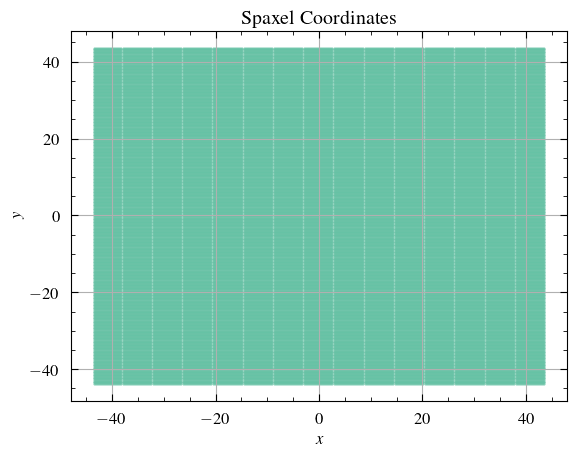

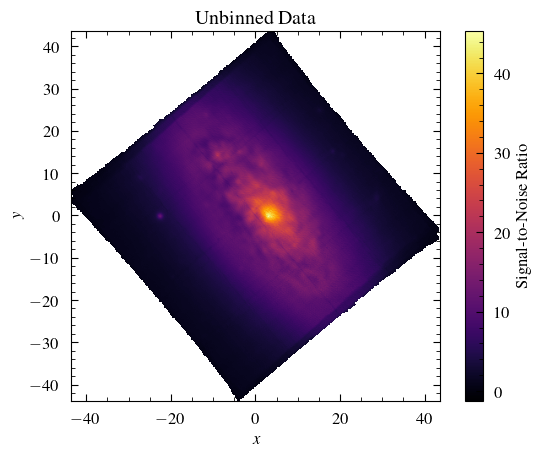

In [3]:
# Ensure coordinates are on a uniform grid
fig, ax = plt.subplots()
ax.scatter(x.flatten(), y.flatten(), s=0.1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Spaxel Coordinates")
plt.show()

# Plot image
fig, ax = plt.subplots()
img = ax.imshow(
    snr, cmap="inferno", origin="lower", extent=[x.min(), x.max(), y.min(), y.max()]
)
cbar = fig.colorbar(img)
cbar.set_label("Signal-to-Noise Ratio")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Unbinned Data")
ax.set_aspect("equal")
ax.grid(False)
plt.show()
# fig, ax = plt.subplots()
# img = ax.contourf(x, y, snr, cmap="inferno", levels=200)
# cbar = fig.colorbar(img)
# cbar.set_label("Signal-to-Noise Ratio")
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_aspect("equal")
# ax.grid(False)
# plt.show()

## Step 1: Regularly bin data to a smaller shape

In [4]:
# First, choose a desired final shape that will be achieved after regularly binning the
# data. Note that each number in the desired shape must be an integer factor of the
# corresponding entry in the array shape.
# Also keep in mind:
# 1. the coordinates don't overlap and point to the same location (i.e., the binned (x, y)
#    coordinate pairs should be distinct)
# 2. the coordinates MUST be on a regular grid
binned_shape = (219, 19)  # CHANGE ME TO FIT YOUR DATA!
if (x.shape[0] % binned_shape[0] != 0) or (x.shape[1] % binned_shape[1] != 0):
    raise ValueError(
        "Each dimension in `binned_shape` must be an integer factor of the original array"
        + "shape!"
    )
num_per_bin = (x.shape[0] // binned_shape[0], x.shape[1] // binned_shape[1])
print("Number of spaxels in a bin (for each axis):", num_per_bin)

Number of spaxels in a bin (for each axis): (2, 23)


### Step 1.1: Create an array of the same shape as the unbinned data to track each data point's bin

In [5]:
bin_nums = np.zeros(x.shape).astype(np.int64)
mybin = 0
for dim1 in range(binned_shape[0]):
    for dim2 in range(binned_shape[1]):
        bin_nums[
            dim1 * num_per_bin[0] : (dim1 + 1) * num_per_bin[0],
            dim2 * num_per_bin[1] : (dim2 + 1) * num_per_bin[1],
        ] = mybin
        mybin += 1
bin_nums

array([[   0,    0,    0, ...,   18,   18,   18],
       [   0,    0,    0, ...,   18,   18,   18],
       [  19,   19,   19, ...,   37,   37,   37],
       ...,
       [4123, 4123, 4123, ..., 4141, 4141, 4141],
       [4142, 4142, 4142, ..., 4160, 4160, 4160],
       [4142, 4142, 4142, ..., 4160, 4160, 4160]])

### Step 1.2: Regularly bin the arrays

In [6]:
# Bin the arrays (note that the binning between arrays MUST be the same, i.e., the order of
# the arguments to `reshape()` must be the same)
reshape_size = (binned_shape[0], num_per_bin[0], binned_shape[1], num_per_bin[1])
x_binned = x.reshape(*reshape_size).sum(axis=3).sum(axis=1) / (
    num_per_bin[0] * num_per_bin[1]
)
y_binned = y.reshape(*reshape_size).sum(axis=3).sum(axis=1) / (
    num_per_bin[0] * num_per_bin[1]
)
signal_binned = np.nansum(np.nansum(signal.reshape(*reshape_size), axis=3), axis=1)
noise_binned = np.sqrt(
    np.nansum(np.nansum(noise.reshape(*reshape_size) ** 2, axis=3), axis=1)
)  # quadrature sum
snr_binned = signal_binned / noise_binned

# Check that the binning reflects the numbers assigned to the bin_nums array
bin_nums_binned = bin_nums.reshape(*reshape_size).sum(axis=3).sum(axis=1) / (
    num_per_bin[0] * num_per_bin[1]
)
with np.printoptions(suppress=True):  # suppress scientific notation
    print("bin nums after binning:", bin_nums_binned, sep="\n")
    # (Should have 1 of each integer without skipping any numbers)

# Exclude unphysical data from Voronoi binning
isgood_binned = (
    np.isfinite(signal_binned)
    & np.isfinite(noise_binned)
    & (signal_binned >= 0)
    & (noise_binned > 0)
)
print("Number of bad binned spaxels:", np.sum(~isgood_binned))
print("Number of good binned spaxels:", np.sum(isgood_binned))

TARGET_SNR = 100
print(
    f"Number of binned spaxels already >= target SNR of {TARGET_SNR}:",
    np.sum(snr_binned[isgood_binned] >= TARGET_SNR),
)

bin nums after binning:
[[   0.    1.    2. ...   16.   17.   18.]
 [  19.   20.   21. ...   35.   36.   37.]
 [  38.   39.   40. ...   54.   55.   56.]
 ...
 [4104. 4105. 4106. ... 4120. 4121. 4122.]
 [4123. 4124. 4125. ... 4139. 4140. 4141.]
 [4142. 4143. 4144. ... 4158. 4159. 4160.]]
Number of bad binned spaxels: 1836
Number of good binned spaxels: 2325
Number of binned spaxels already >= target SNR of 100: 140


/tmp/ipykernel_37255/4244645459.py:14: RuntimeWarning: invalid value encountered in divide
  snr_binned = signal_binned / noise_binned


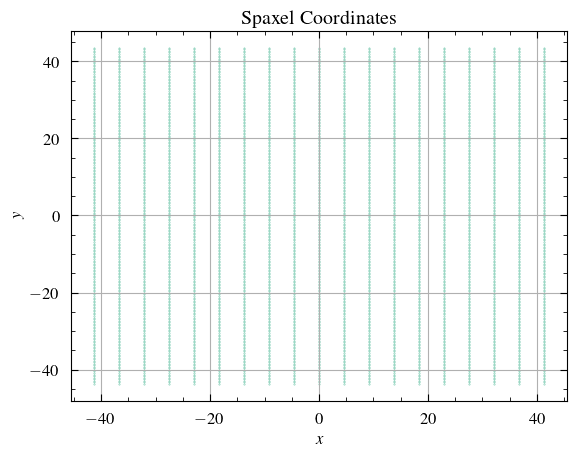

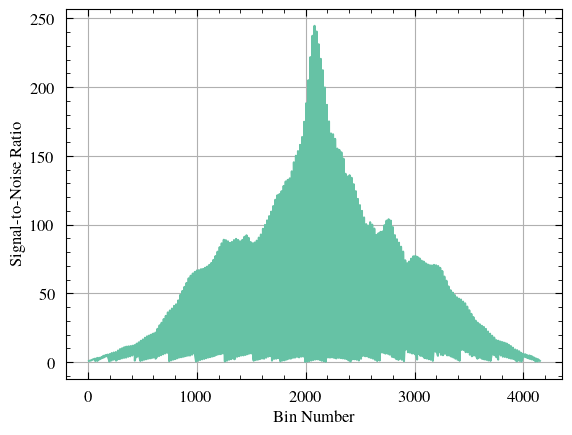

In [7]:
# Show some diagnostic plots to make sure everything went okay
fig, ax = plt.subplots()
ax.scatter(x_binned.flatten(), y_binned.flatten(), s=0.1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Spaxel Coordinates")
plt.show()

fig, ax = plt.subplots()
ax.plot(bin_nums_binned[isgood_binned], snr_binned[isgood_binned])
ax.set_ylabel("Signal-to-Noise Ratio")
ax.set_xlabel("Bin Number")
plt.show()

## Step 2: Apply Voronoi binning to the regularly binned data

Voronoi binning of the regularly-binned data took 1.08 seconds


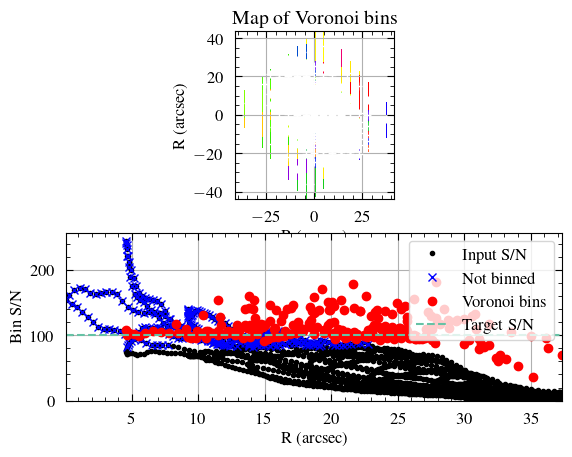

In [8]:
starttime = time.time()
vorbin_nums, _, _, _, _, vorbin_snr, npix_per_vorbin, _ = voronoi_2d_binning(
    x_binned[isgood_binned],
    y_binned[isgood_binned],
    signal_binned[isgood_binned],
    noise_binned[isgood_binned],
    TARGET_SNR,
    plot=True,
)
endtime = time.time()
print(
    "Voronoi binning of the regularly-binned data took "
    + f"{(endtime - starttime):.2f} seconds"
)

### Step 2.1: Assign each _full-resolution_ pixel to its Voronoi bin


In [9]:
# Arrays to track final Voronoi binning results
signal_vorbinned = signal.copy()
noise_vorbinned = noise.copy()
snr_vorbinned = snr.copy()

# Arrays to track data that were not Voronoi binned
signal_to_vorbin = np.full_like(signal, np.nan)
noise_to_vorbin = np.full_like(noise, np.nan)

for mybin, snr_of_bin, npix in zip(np.unique(vorbin_nums), vorbin_snr, npix_per_vorbin):
    if npix == 1:  # unbinned spaxel
        # Transform back into full-resolution data
        is_in_vorbin = vorbin_nums == mybin  # at rebinned resolution
        full_res_is_in_vorbin = bin_nums == bin_nums_binned[isgood_binned][is_in_vorbin]

        signal_to_vorbin[full_res_is_in_vorbin] = signal[full_res_is_in_vorbin]
        noise_to_vorbin[full_res_is_in_vorbin] = noise[full_res_is_in_vorbin]

    else:  # binned spaxel
        # Determine which full resolution spaxels correspond to this Voronoi bin
        is_in_vorbin = vorbin_nums == mybin  # at rebinned resolution
        bin_nums_in_vorbin = bin_nums_binned[isgood_binned][is_in_vorbin]
        full_res_is_in_vorbin = bin_nums == bin_nums_in_vorbin.min()
        for full_res_bin in bin_nums_in_vorbin[1:]:
            full_res_is_in_vorbin = full_res_is_in_vorbin | (bin_nums == full_res_bin)
        # `full_res_is_in_vorbin` is a boolean array of the same shape as the full
        # resolution data that tells us the (full resolution) data points that are in the
        # current Voronoi bin

        # Calculate signal and noise (since we only have SNR but not the values of S or N)
        signal_of_bin = np.nansum(signal[full_res_is_in_vorbin])
        noise_of_bin = np.sqrt(np.nansum(noise[full_res_is_in_vorbin] ** 2))
        signal_vorbinned[full_res_is_in_vorbin] = signal_of_bin
        noise_vorbinned[full_res_is_in_vorbin] = noise_of_bin
        snr_vorbinned[full_res_is_in_vorbin] = snr_of_bin

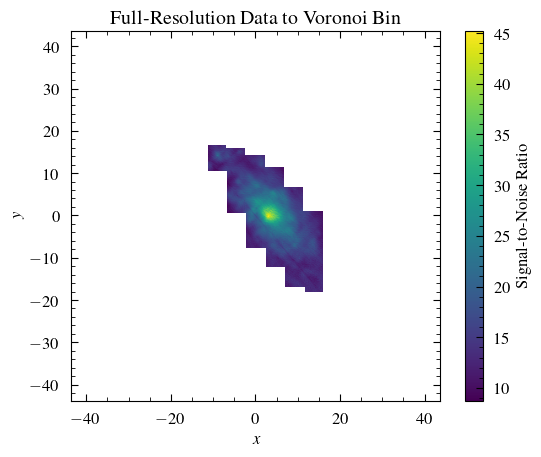

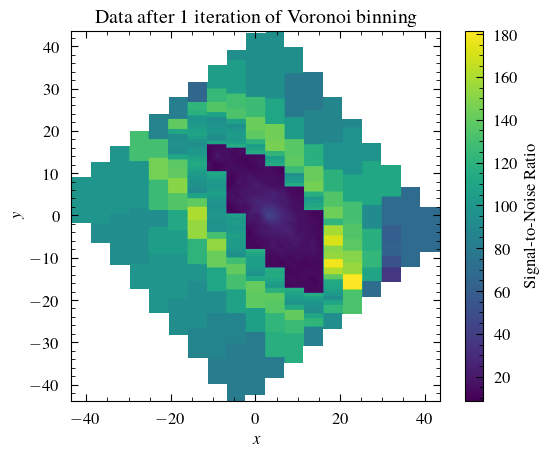

In [10]:
# See what the current data are like after 1 iteration of Voronoi binning

fig, ax = plt.subplots()
img = ax.imshow(
    signal_to_vorbin / noise_to_vorbin,
    cmap="viridis",
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
)
cbar = fig.colorbar(img)
cbar.set_label("Signal-to-Noise Ratio")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Full-Resolution Data to Voronoi Bin")
ax.set_aspect("equal")
ax.grid(False)


fig, ax = plt.subplots()
img = ax.imshow(
    snr_vorbinned,
    cmap="viridis",
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
)
cbar = fig.colorbar(img)
cbar.set_label("Signal-to-Noise Ratio")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Data after 1 iteration of Voronoi binning")
ax.set_aspect("equal")
ax.grid(False)

## Step 3: Run Voronoi binning on just the full-resolution pixels that have not been previously Voronoi-binned

### Step 3.1: Create a 2D array to track each data point's bin

In [11]:
is_to_vorbin = (
    np.isfinite(signal_to_vorbin)
    & np.isfinite(noise_to_vorbin)
    & (signal_to_vorbin >= 0)
    & (noise_to_vorbin > 0)
)

_bin_num_ref = np.arange(x.size).reshape(x.shape)
bin_nums2 = np.where(is_to_vorbin, _bin_num_ref, np.nan)
# `bin_nums2` is a 2D array that gives a unique number to each spaxel, which will allow us
# to determine which pixels belong in which Voronoi bin

### Step 3.2: Run Voronoi binning on the connected regions of the full-resolution pixels

Voronoi binning on this subset of the full-resolution data took 4.77 seconds


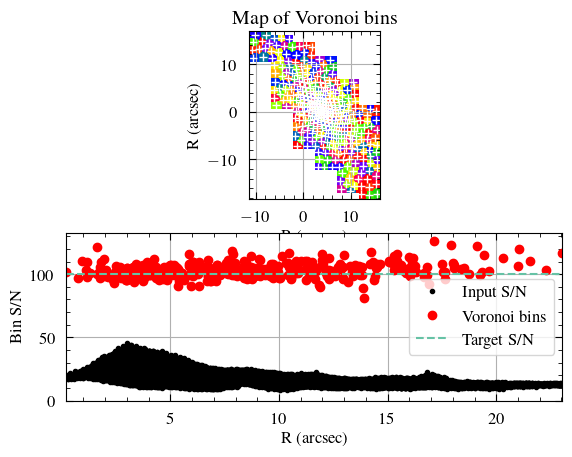

In [12]:
# Apply Voronoi binning to the full-resolution data that have not been Voronoi-binned
starttime = time.time()
vorbin_nums, _, _, _, _, vorbin_snr, npix_per_vorbin, _ = voronoi_2d_binning(
    x[is_to_vorbin],
    y[is_to_vorbin],
    signal[is_to_vorbin],
    noise[is_to_vorbin],
    TARGET_SNR,
    pixelsize=0.2,
    plot=True,
)
endtime = time.time()
print(
    "Voronoi binning on this subset of the full-resolution data took "
    + f"{(endtime - starttime):.2f} seconds"
)

### Step 3.1: Assign full-resolution pixels to their Voronoi bin

In [13]:
for mybin, snr_of_bin in zip(np.unique(vorbin_nums), vorbin_snr):
    # Determine which full resolution spaxels correspond to this Voronoi bin
    is_in_vorbin = vorbin_nums == mybin
    bin_nums2_in_vorbin = bin_nums2[is_to_vorbin][is_in_vorbin]
    full_res_is_in_vorbin = np.abs(bin_nums2 - bin_nums2_in_vorbin.min()) < 1e-10
    for full_res_bin in np.unique(bin_nums2_in_vorbin)[1:]:
        full_res_is_in_vorbin = full_res_is_in_vorbin | (bin_nums2 == full_res_bin)
    # `full_res_is_in_vorbin` is a boolean array of the same shape as the full
    # resolution data that tells us the (full resolution) data points that are in the
    # current Voronoi bin

    # Calculate signal and noise (since we only have SNR but not the values of S or N)
    signal_of_bin = np.nansum(signal[full_res_is_in_vorbin])
    noise_of_bin = np.sqrt(np.nansum(noise[full_res_is_in_vorbin] ** 2))
    signal_vorbinned[full_res_is_in_vorbin] = signal_of_bin
    noise_vorbinned[full_res_is_in_vorbin] = noise_of_bin
    snr_vorbinned[full_res_is_in_vorbin] = snr_of_bin

## Final Results

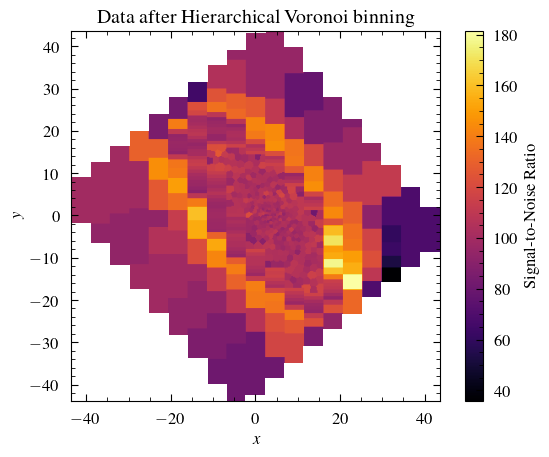

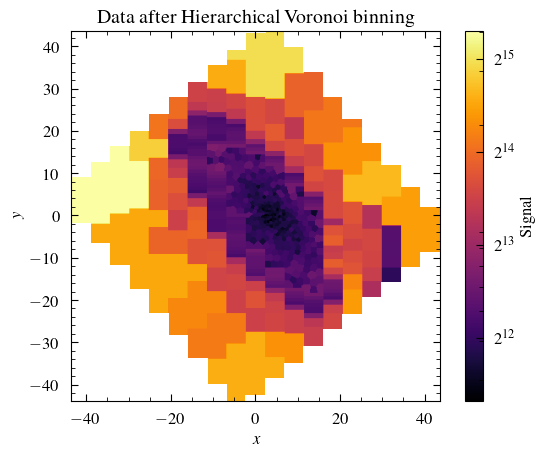

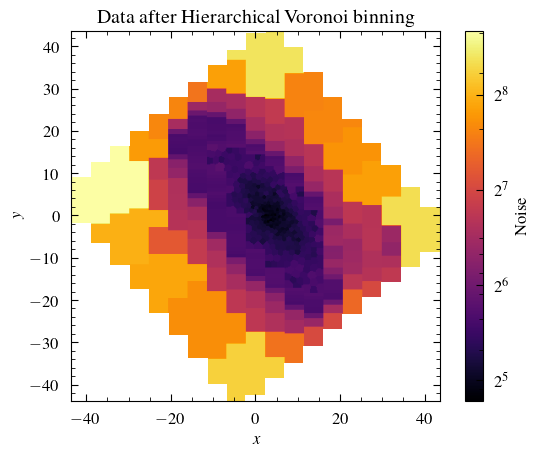

In [14]:
fig, ax = plt.subplots()
img = ax.imshow(
    snr_vorbinned,
    cmap="inferno",
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
)
cbar = fig.colorbar(img)
cbar.set_label("Signal-to-Noise Ratio")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Data after Hierarchical Voronoi binning")
ax.set_aspect("equal")
ax.grid(False)
plt.show()

fig, ax = plt.subplots()
img = ax.imshow(
    signal_vorbinned,
    cmap="inferno",
    origin="lower",
    norm=LogNorm(vmin=np.nanmin(signal_vorbinned), vmax=np.nanmax(signal_vorbinned)),
    extent=[x.min(), x.max(), y.min(), y.max()],
)
cbar_locator = LogLocator(base=2)
cbar_formatter = LogFormatterSciNotation(base=2)
cbar = fig.colorbar(img, ax=ax, ticks=cbar_locator, format=cbar_formatter)
cbar.set_label("Signal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Data after Hierarchical Voronoi binning")
ax.set_aspect("equal")
ax.grid(False)
plt.show()

fig, ax = plt.subplots()
img = ax.imshow(
    noise_vorbinned,
    cmap="inferno",
    origin="lower",
    norm=LogNorm(vmin=np.nanmin(noise_vorbinned), vmax=np.nanmax(noise_vorbinned)),
    extent=[x.min(), x.max(), y.min(), y.max()],
)
cbar_locator = LogLocator(base=2)
cbar_formatter = LogFormatterSciNotation(base=2)
cbar = fig.colorbar(img, ax=ax, ticks=cbar_locator, format=cbar_formatter)
cbar.set_label("Noise")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Data after Hierarchical Voronoi binning")
ax.set_aspect("equal")
ax.grid(False)
plt.show()